In [2]:
# in this version of the pipeline, we include all features--including categorical ones, which have been transformed 
# with pandas' .get_dummies(). this increases the number of features from 17 in pt4 to 977.

In [3]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper')

In [4]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [5]:
features_train = select('select * from final_features_train')
features_test = select('select * from final_features_test')
targets_train = select('select * from final_targets_train').loan_status
targets_test = select('select * from final_targets_test').loan_status

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [7]:
lr = LogisticRegression().fit(features_train,targets_train)
GNB = GaussianNB().fit(features_train,targets_train)
KNN = KNeighborsClassifier().fit(features_train,targets_train)

In [8]:
# on baseline evaluation, neg recall is slightly improved when we include categorical information w/ get_dummies !
# recall on minority class is no longer ~ 0 %, it is at about 2%; next, we repeat the whole pipeline. 2% doesn't seem
# significant, but it is orders of magnitude above the previous ~0.01% performance
# GNB and KNN have better recall than in the baseline (numerical-only) models

# note: KNN seems to be one of the algorithms that is sensitive to dimension of feature space. takes a while to run

print(classification_report(targets_test,lr.predict(features_test)))
print(classification_report(targets_test,GNB.predict(features_test)))
print(classification_report(targets_test,KNN.predict(features_test)))

             precision    recall  f1-score   support

          0       0.42      0.02      0.03      8804
          1       0.83      1.00      0.90     41670

avg / total       0.76      0.82      0.75     50474

             precision    recall  f1-score   support

          0       0.32      0.34      0.33      8804
          1       0.86      0.85      0.85     41670

avg / total       0.77      0.76      0.76     50474

             precision    recall  f1-score   support

          0       0.30      0.11      0.16      8804
          1       0.83      0.94      0.89     41670

avg / total       0.74      0.80      0.76     50474



In [9]:
# undersampling ratio, SMOTE oversampling ratio, ADASYN oversampling ratio. all 1:1

ratios = [{0:len(features_train[~targets_train.astype(bool)]),\
               1:len(features_train[~targets_train.astype(bool)])},\
         {0:len(features_train[targets_train.astype(bool)]),\
                1:len(features_train[targets_train.astype(bool)])},\
         {0:len(features_train[targets_train.astype(bool)]),\
                1:len(features_train[targets_train.astype(bool)])}]

In [10]:
def Pipeline0(features,targets,model,resample_ratios,metric):
    
    resamplers = [None,RandomUnderSampler,SMOTE,ADASYN]
    resampler_names = ['UnderSamp','SMOTE','ADASYN']
    output = {}
    output['model'] = model[0]
    i = 0
    
    for resampler in resamplers:
        if resampler == None:
            final_features = features.copy()
            final_targets = targets.copy()
            tn,fp,fn,tp = confusion_matrix(targets_test,model[1].fit(final_features,final_targets).predict(features_test)).ravel()
            
            
            output['N_pre'] = tn/(tn+fn)
            output['N_rec'] = tn/(tn+fp)
            
            output['P_pre'] = tp/(tp+fp)
            output['P_rec'] = tp/(tp+fn)
            
        else:
            final_features, final_targets = resampler(ratio=resample_ratios[i]).fit_sample(features,targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,model[1].fit(final_features,final_targets).predict(features_test)).ravel()
            
            
            output[resampler_names[i]+'_N_pre'] = tn/(tn+fn)
            output[resampler_names[i]+'_N_rec'] = tn/(tn+fp)
            
            output[resampler_names[i]+'_P_pre'] = tp/(tp+fp)
            output[resampler_names[i]+'_P_rec'] = tp/(tp+fn)
                
            i+=1
    
    return output

In [11]:
# optimize hyperparameters for F1 score on negative class, since that is the area we're looking to improve

def neg_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tn/(tn+fn)
    recall = tn/(tn+fp)
    return 2*(precision*recall)/(precision+recall)

def pos_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return 2*(precision*recall)/(precision+recall)

# the metric to optimize for in the regularized runs of the pipeline will determine the appropriate score function

score_dict = {'neg':neg_f1,'pos':pos_f1}

In [12]:
def Pipeline1(features,targets,model,resample_ratios,metric):
    
    resamplers = [None,RandomUnderSampler,SMOTE,ADASYN]
    resampler_names = ['UnderSamp','SMOTE','ADASYN']
    output = {}
    output['model'] = 're'+model[0]
    i = 0
    
    if model[0] == 'LR':
        params = {'C':[.001,.01,.1,1,10,100]}
    elif model[0] == 'GNB': 
        params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}
    elif model[0] == 'KNN':
        params = {'n_neighbors':list(range(3,8))}
    elif model[0] == 'RF':
        params = {'max_depth':[2,4,8,16,32,100]}
    elif model[0] == 'QDA':
        params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}
    
    for resampler in resamplers:
        if resampler == None:
            final_features = features.copy()
            final_targets = targets.copy()
            clf = GridSearchCV(model[1],param_grid=params,scoring=make_scorer(score_dict[metric]),return_train_score=True)\
                                .fit(final_features,final_targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,clf.best_estimator_.predict(features_test)).ravel()
            
            
            output['N_pre'] = tn/(tn+fn)
            output['N_rec'] = tn/(tn+fp)
            
            output['P_pre'] = tp/(tp+fp)
            output['P_rec'] = tp/(tp+fn)
            
        else:
            final_features, final_targets = resampler(ratio=resample_ratios[i]).fit_sample(features,targets)
            clf = GridSearchCV(model[1],param_grid=params,scoring=make_scorer(score_dict[metric]),return_train_score=True)\
                                .fit(final_features,final_targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,clf.best_estimator_.predict(features_test)).ravel()
            
            
            output[resampler_names[i]+'_N_pre'] = tn/(tn+fn)
            output[resampler_names[i]+'_N_rec'] = tn/(tn+fp)
            
            output[resampler_names[i]+'_P_pre'] = tp/(tp+fp)
            output[resampler_names[i]+'_P_rec'] = tp/(tp+fn)
                
            i+=1
    
    return output

In [13]:
def PipelineLayer1(model,metric,ratio_dicts):
    unregularized = Pipeline0(features=features_train,targets=targets_train,\
                             model=model,resample_ratios=ratio_dicts,metric=metric)
    
    regularized = Pipeline1(features=features_train,targets=targets_train,\
                            model=model,resample_ratios=ratio_dicts,metric=metric)
    return pd.DataFrame(unregularized,index=[0]).set_index('model')\
                    .append(pd.DataFrame(regularized,index=[0]).set_index('model')).copy()

In [14]:
def PipelineLayer2(model_list,metric,ratios):
    
    tempdf = pd.DataFrame()
    
    for model in model_list:
        tempdf = tempdf.append(PipelineLayer1(model,metric,ratios))
        
    return tempdf.copy()

In [15]:
# cat_results = PipelineLayer2(algs,metric='neg',ratios=ratios)

In [16]:
# ^ computationally infeasible. did not complete after 1.5 hours of computing on a modern cpu (late 2017 model consumer pc)

# reduce categorical columns w PCA, do analysis, and try running again with reduced feature space

# use different unsupervised learning algorithms on the transformed categorical features (dummy variables)
# to find clusters in the categories. (we do not include the original features yet, since their values will reduce 
# the influence of the categorical features which artificially have been given values 0/1 on the dummy variables)
# we will run unsupervised learning algorithms on the original numerical features separately.

# we will make these clusters new features, and use .get_dummies() again and run unsupervised learning algs another time.
# this is an ensemble-approach to unsupervised learning, with the hope that it'll find more complex structure by 
# using information from different clustering approaches. finally, we will run .get_dummies() a last time before 
# inputting the final clusterings to 

In [17]:
# the categorical columns (which have already been transformed to numerical dummies) which we want to reduce w PCA

catcolumns = list(features_train.columns)
catcolumns = catcolumns[11:]

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=50).fit(features_train[catcolumns])

Text(0.5,0,'Components')

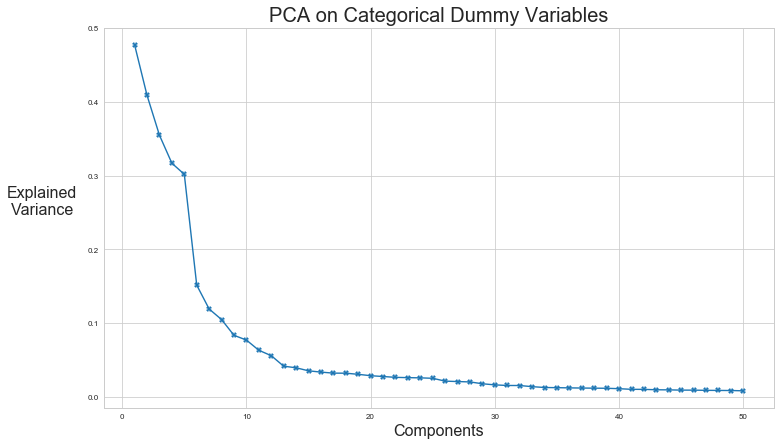

In [20]:
# there is a steep drop in EV on the 6th additional component. visual analysis suggests we project the features onto a 
# 5 dimensional subspace, but EV reduction does not level off until after around 12 dimensions. using 12 dimensions should be
# computationally feasible. we will use 12 instead of 5, to not reduce the complexity too much (and risk losing information)

fig, ax = plt.subplots(1,1,figsize=(12,7))

ax.plot(list(range(1,51)),pca.explained_variance_,'X-')
ax.set_title('PCA on Categorical Dummy Variables',fontsize=20)
ax.set_ylabel('Explained\nVariance',fontsize=16,rotation=0,labelpad=45)
ax.set_xlabel('Components',fontsize=16)

In [21]:
pca = PCA(n_components=12).fit(features_train[catcolumns])

In [22]:
# transform represents the categorical dummy features reduced to a 12 dimensional feature space via PCA

transform = pd.DataFrame(pca.transform(features_train[catcolumns]))

In [23]:
# the training data, with categorical features reduced to 12 components. now, we have a much more computationally manageable
# feature space dimension of 23. unsupervised learning algorithms can also now be applied (on a baseline test run, k-means
# took too long to finish fitting)

numerical = list(set(features_train)-set(catcolumns))
features_train_T = features_train[numerical].merge(transform,left_index=True,right_index=True).copy()

In [24]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

In [25]:
# not enough memory in RAM to run silhouette score on the full training set.. we will compute 
# silhouette score on a random sample. computing the silhouette score is fairly computationally expensive.. saving
# results to eliminate need for re-running that bit of code

#ss = []
#sil_avgs = []

#for n in range(2,51):
 #   KM = KMeans(n_clusters=n,random_state=2).fit(features_train_T[list(range(12))])
    #ss.append(KM.inertia_)
    
    #labeled_features = features_train_T[list(range(12))].merge(pd.DataFrame(KM.labels_),\
     #                                                          left_index=True,right_index=True).copy()
    #sil_avgs.append(silhouette_score(labeled_features.sample(30000,random_state=2).drop('0_y',axis=1),\
     #            labeled_features.sample(30000,random_state=2)['0_y']))

In [26]:
# the computation takes a while to complete.. we save the results to eliminate the need to re-run

#pd.DataFrame(ss).to_csv('./data/category-sum-of-squares.csv')
#pd.DataFrame(sil_avgs).to_csv('./data/category-silhouette-avgs.csv')

ss = list(pd.read_csv('./data/category-sum-of-squares.csv').drop('Unnamed: 0',axis=1)['0'])
sil_avgs = list(pd.read_csv('./data/category-silhouette-avgs.csv').drop('Unnamed: 0',axis=1)['0'])

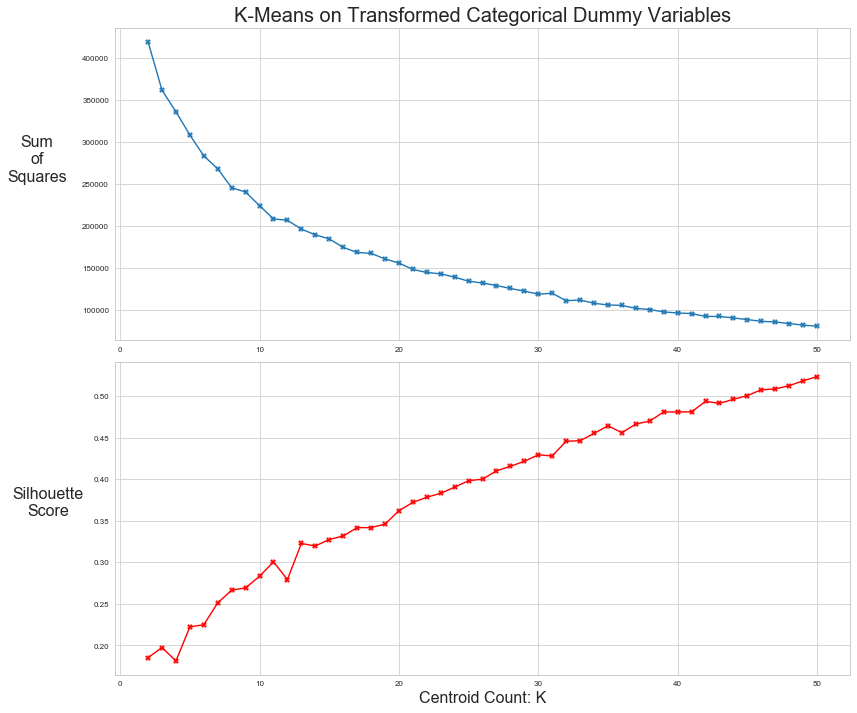

In [27]:
# there is not a very obvious choice for k using analysis of sum of squares reduction -- SoS seems to continue to decrease
# without leveling off even after 50 centroids are used. silhouette score is equally difficult to use to conclude an
# optimal number of clusters--it seems to keep increasing (though not monotonically) with the cluster count

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10))

ax1.plot(list(range(2,51)),ss,'X-')
ax1.set_title('K-Means on Transformed Categorical Dummy Variables',fontsize=20)
ax1.set_ylabel('Sum\nof\nSquares',fontsize=16,rotation=0,labelpad=45)

ax2.plot(list(range(2,51)),sil_avgs,'Xr-')
ax2.set_ylabel('Silhouette\nScore',fontsize=16,rotation=0,labelpad=45)
ax2.set_xlabel('Centroid Count: K',fontsize=16)

plt.tight_layout()

In [28]:
# for DBSCAN, we will study the % of data that is classified as noise to determine hyperparam values. first, epsilon:
# the minimum euclidean distance between data points for them to be placed in the same cluster
# -1 is the label for points classified as noise

# we don't use grid search, since a scoring function to minimize percentage noise will end up overfitting
# (it'll return the param values which cause 0% noise)

#epsilons = [0.00005,0.0005,0.005,0.05,0.5,1]
#percentage = []

#for ep in epsilons:
 #   DB = DBSCAN(eps=ep).fit(features_train_T[list(range(12))])
  #  if -1 not in DB.labels_:
   #     percentage.append(0)
    #    continue
    #percentage.append(pd.Series(DB.labels_).value_counts().loc[-1]/len(features_train_T))

In [29]:
# next: the minimum number of data points in a cluster for the cluster to not be considered noise, all with epsilon = 0.5

#min_samples = [5,10,20,30,40,50,70,100]
#percentage1 = []

#for ms in min_samples:
 #   DB = DBSCAN(min_samples=ms).fit(features_train_T[list(range(12))])
  #  if -1 not in DB.labels_:
   #     percentage1.append(0)
    #    continue
    #percentage1.append(pd.Series(DB.labels_).value_counts().loc[-1]/len(features_train_T))

In [30]:
# the computation takes a while to complete.. we save the results to eliminate the need to re-run

#pd.DataFrame(percentage).to_csv('./data/category-epsilons-results.csv')
#pd.DataFrame(percentage1).to_csv('./data/category-min-samples-results.csv')

#percentage = list(pd.read_csv('./data/category-epsilons-results.csv').drop('Unnamed: 0',axis=1)['0'])
#percentage1 = list(pd.read_csv('./data/category-min-samples-results.csv').drop('Unnamed: 0',axis=1)['0'])

In [31]:
# epsilon = 0.5 seems to be the ideal param value out of the tested values. 

#fig, ax = plt.subplots(1,1,figsize=(12,5))

#ax.plot(epsilons,np.array(percentage)*100,'X-')
#ax.set_ylabel('% Noise',rotation=0,labelpad=45,fontsize=16)
#ax.set_xlabel('Epsilon',fontsize=16)
#ax.set_title('DBSCAN on Transformed Dummy Variables',fontsize=20)

In [32]:
# again, the results do not indicate a very clear answer. use 30
# ultimately, this is an intermediary step before we enter the values into the predictive models and there may not be 
# a large impact on the final model performance

#fig, ax = plt.subplots(1,1,figsize=(12,5))

#ax.plot(min_samples,np.array(percentage1)*100,'X-')
#ax.set_ylabel('% Noise',rotation=0,labelpad=45,fontsize=16)
#ax.set_xlabel('Minimum Samples per Cluster',fontsize=16)
#ax.set_title('DBSCAN on Transformed Dummy Variables',fontsize=20)

In [33]:
KM = KMeans(n_clusters=30).fit(features_train_T[list(range(12))])
KMlabels = KM.labels_
#DB = DBSCAN(eps=0.5,min_samples=30).fit(features_train_T[list(range(12))])
#DBlabels = DB.labels_

In [34]:
clusters = pd.get_dummies(KMlabels)
#pca = PCA(n_components=20).fit(clusters)

In [35]:
# we must use PCA again on the cluster dummies, since DBSCAN results in about 375 clusters. 
# use 9 components

#fig, ax = plt.subplots(1,1,figsize=(12,7))

#ax.plot(list(range(1,21)),pca.explained_variance_,'X-')
#ax.set_title('PCA on Cluster Dummy Variables',fontsize=20)
#ax.set_ylabel('Explained\nVariance',fontsize=16,rotation=0,labelpad=45)
#ax.set_xlabel('Components',fontsize=16)

In [36]:
#pca = PCA(n_components=9).fit(clusters)
clusters_T = clusters

In [37]:
features_train_F = features_train_T.drop(list(range(12)),axis=1)\
    .merge(pd.DataFrame(clusters_T),left_index=True,right_index=True).copy()

In [38]:
# at this point we realize we cannot use DBSCAN, since the algorithm works in such a way that new data points cannot be 
# classified to clusters which were fit on the training data. we cannot even add the new data points to the training data
# and re-run DBSCAN, since that changes the overall structure of the data and could cause different clustering to form

# since we don't run DBSCAN, we don't need to run PCA a second time. DBSCAN was originally causing 370+ new features to be
# added after running get_dummies(), which created a need for dimensionality reduction. we only have 30 clusters with
# KMeans, which does not increase computational overhead excessively 

In [39]:
# we must transform the test data using the same steps, but we must classify the new data based on the clusters established
# from running KMeans on the training data. 

# 'numerical' is taken from global scope. instantiated when establishing features_train_T
# we use it because we want to ensure features_train_T and features_test_T have the same ordering of columns

def transform_categories(features_train,features_test,categories,cluster):
    
    pca = PCA(n_components=12).fit(features_train[categories]) # establish subspace components to project onto
    KM = KMeans(n_clusters=30).fit(pca.transform(features_train[categories])) # establish clusters amongst categories
    
    transform = pd.DataFrame(pca.transform(features_test[categories])) # reduce dimensions of categories
    features_test_T = features_test[numerical]\
        .merge(transform,left_index=True,right_index=True).copy() # append reduced categories to numerical columns
        
    if cluster == False:
        return features_test_T
    
    KMlabels = KM.predict(transform)
    clusters = pd.get_dummies(KMlabels)
    features_test_F = features_test_T.drop(list(range(12)),axis=1)\
        .merge(pd.DataFrame(clusters),left_index=True,right_index=True).copy()
    
    return features_test_F

In [40]:
features_test_F = transform_categories(features_train,features_test,categories=catcolumns,cluster=True)

In [41]:
# running PCA and then KMeans in our series of transformations reduces recall a bit compared to when we run these algs
# on the entire feature space (non-reduced dimensions), including dummies of categorical faetures. however, these
# are all still better than the baseline version that does not include these categorical features

# this may not make sense, however.. since we remove the categorical dummy variables and insert 30 clusters which are 
# also transformed into dummy variables. may as well just keep the original categorical dummy variables? i.e., let's
# also test the performance without clustering. (we still run PCA to reduce the dimension)

lr = LogisticRegression().fit(features_train_F,targets_train)
print(classification_report(targets_test,lr.predict(features_test_F)))
GNB = GaussianNB().fit(features_train_F,targets_train)
print(classification_report(targets_test,GNB.predict(features_test_F)))
KNN = KNeighborsClassifier().fit(features_train_F,targets_train)
print(classification_report(targets_test,KNN.predict(features_test_F)))

             precision    recall  f1-score   support

          0       0.42      0.03      0.05      8804
          1       0.83      0.99      0.90     41670

avg / total       0.76      0.82      0.75     50474

             precision    recall  f1-score   support

          0       0.31      0.31      0.31      8804
          1       0.85      0.86      0.86     41670

avg / total       0.76      0.76      0.76     50474

             precision    recall  f1-score   support

          0       0.30      0.11      0.16      8804
          1       0.83      0.94      0.89     41670

avg / total       0.74      0.80      0.76     50474



In [42]:
# run without bothering with clustering. still reduce categorical dummies to 12 dimensions.

In [43]:
# this version uses the PCA-reduced categorical columns instead of the clusters. however, we also need to train the 
# models with the same features

features_test_T = transform_categories(features_train,features_test,categories=catcolumns,cluster=False)

In [44]:
# results are more or less the same as in the case with clustering. clustering has no benefit (it actually adds 
# computational expense, since we use 30 clusters rather than 12 PCA reduced dimensions)

lr1 = LogisticRegression().fit(features_train_T,targets_train)
print(classification_report(targets_test,lr1.predict(features_test_T)))
GNB1 = GaussianNB().fit(features_train_T,targets_train)
print(classification_report(targets_test,GNB1.predict(features_test_T)))
KNN1 = KNeighborsClassifier().fit(features_train_T,targets_train)
print(classification_report(targets_test,KNN1.predict(features_test_T)))

             precision    recall  f1-score   support

          0       0.42      0.02      0.03      8804
          1       0.83      0.99      0.90     41670

avg / total       0.76      0.82      0.75     50474

             precision    recall  f1-score   support

          0       0.32      0.33      0.33      8804
          1       0.86      0.85      0.85     41670

avg / total       0.76      0.76      0.76     50474

             precision    recall  f1-score   support

          0       0.30      0.11      0.16      8804
          1       0.83      0.94      0.89     41670

avg / total       0.74      0.80      0.76     50474



---

In [45]:
# now, we can finally run the entire pipeline again. we will run it twice: once with clustering and once without clustering

In [46]:
# Random Forest will prob do poorly-- it takes a random subset of features for each tree, but much of the features (about half)
# are dummy variables from the categorical conversion + PCA transformation. most of the trees in the ensemble would be
# built on features that are not very undescriptive. these dummy variables can potentially aid in prediction if they are
# used together with the main features, but have little predictive value on their own. 

algs = [('LR',LogisticRegression()),('GNB',GaussianNB()),('KNN',KNeighborsClassifier()),('RF',RandomForestClassifier())]

In [47]:
# features_train and features_test are used within the pipeline function, but not as arguments. they take the 
# data from the global scope, so we must assign to those variables the transformed versions
# (features_train_T established while developing the transform_cateogries; features_test_T is obtained from running the func)

features_train = features_train_F
features_test = features_test_F

In [48]:
#cluster_results = PipelineLayer2(algs,metric='neg',ratios=ratios)

In [49]:
#cluster_results.to_csv('.\data\category-results-clustering.csv')

cluster_results = pd.read_csv('.\data\category-results-clustering.csv').set_index('model')

In [50]:
# without clustering

features_train = features_train_T
features_test = features_test_T

In [51]:
#no_cluster_results = PipelineLayer2(algs,metric='neg',ratios=ratios)

In [52]:
#no_cluster_results.to_csv('.\data\category-results-no-clustering.csv')

no_cluster_results = pd.read_csv('.\data\category-results-no-clustering.csv').set_index('model')

---

In [53]:
neg = ['N_pre','N_rec','UnderSamp_N_pre','UnderSamp_N_rec','SMOTE_N_pre','SMOTE_N_rec','ADASYN_N_pre','ADASYN_N_rec']

In [54]:
# woah.. clustering greatly improves model performance, in particular ADASYN GNB recall
# note - this is all with a 1:1 ratio after resampling. we can still play with the ratios after establishing
# desired (and feasible) levels of precision/recall

cluster_results[neg]

,N_pre,N_rec,UnderSamp_N_pre,UnderSamp_N_rec,SMOTE_N_pre,SMOTE_N_rec,ADASYN_N_pre,ADASYN_N_rec
model,,,,,,,,
LR,0.427136,0.019309,0.273490,0.625511,0.271991,0.629373,0.256371,0.708428
reLR,0.404494,0.008178,0.273836,0.625057,0.272186,0.627783,0.256325,0.708882
GNB,0.316061,0.320082,0.270894,0.566220,0.241990,0.727510,0.209674,0.825193
reGNB,0.270347,0.562926,0.256158,0.647319,0.227005,0.800886,0.200532,0.873807
KNN,0.297207,0.111199,0.227424,0.588142,0.223180,0.497160,0.242788,0.286801
reKNN,0.264309,0.251249,0.209091,0.735120,0.223570,0.445820,0.246706,0.287142
RF,0.302279,0.138573,0.227376,0.684348,0.302046,0.199568,0.292909,0.182985
reRF,0.308200,0.137892,0.259681,0.679464,0.328131,0.183894,0.315528,0.108019


In [55]:
# need to compare with the other pipeline results, but indeed..random forest seems to be performing very poorly

no_cluster_results[neg]

,N_pre,N_rec,UnderSamp_N_pre,UnderSamp_N_rec,SMOTE_N_pre,SMOTE_N_rec,ADASYN_N_pre,ADASYN_N_rec
model,,,,,,,,
LR,0.426554,0.017151,0.274980,0.635166,0.274922,0.633689,0.257353,0.714562
reLR,0.402256,0.012154,0.274669,0.632326,0.271399,0.634939,0.255227,0.715470
GNB,0.318875,0.332349,0.274333,0.566333,0.262404,0.618128,0.231312,0.685711
reGNB,0.261056,0.644366,0.260950,0.642890,0.248248,0.696274,0.220014,0.760904
KNN,0.300030,0.111881,0.230889,0.587347,0.225715,0.508065,0.244896,0.290209
reKNN,0.265069,0.251249,0.208885,0.733303,0.223567,0.448887,0.244571,0.283962
RF,0.316195,0.144593,0.230510,0.690482,0.300139,0.196161,0.301639,0.177647
reRF,0.317656,0.149591,0.265471,0.647547,0.347698,0.120968,0.375723,0.066447


In [59]:
#conn = sqlite3.connect('.\data\lending-club-loan-data\database2.sqlite')

#features_train_F.to_sql('final_cluster_features_train',conn,index=False)
#features_test_F.to_sql('final_cluster_features_test',conn,index=False)

#features_train_T.to_sql('final_cat_features_train',conn,index=False)
#features_test_T.to_sql('final_cat_features_test',conn,index=False)

#conn.close()